In [50]:
import numpy as np
import sys
sys.path.append('..')
from utils.util import *
import matplotlib.pyplot as plt
import warnings
# warnings.simplefilter('error', UserWarning)
warnings.simplefilter("default")
# start 6 at 10:50, 5 steps 11:07 - 1:03 stape 2 run 7
import seaborn as sns
sns.reset_defaults()
sns.set_style("whitegrid") #  {darkgrid, whitegrid, dark, white, ticks}
# sns.set_context("paper")
sns.set_context("talk")


# Steps for the analysis

#### 1. Group based on the congeuncy and fill out the missing values by nan

#### 2. Then for each run, for each congeuncy group:
##### 2.1. Remove any outliers (those that very big and very small): abs(data)>1
##### 2.2. Do an interpolation on the rest of the data to replace nans

#### 3. Average over all the runs 

#### 4. Plot each congeuncy group 

In [5]:
args_dict = {}
args_dict['analyze_names'] = ['calc_ratio']
args_dict = set_args_dict(args_dict)

## Read the results

In [6]:
analyze_name = args_dict['analyze_names'][0]

# ----------------------
ctx_order = 'first'
ctx_order_str = 'ctxF'
# ----------------------
with open('../../results/%s_results_rnn_sbs.P' %(ctx_order_str), 'rb') as f:
    ctxF_results_rnn_sbs = pickle.load(f)

ctxF_results_rnn_sbs['Cortical'].keys()

dict_keys(['loss', 'train_acc', 'test_acc', 'analyze_acc', 'analyze_correct', 'analysis', 'cortical_runs_ratio_diffs'])

In [8]:
cortical_runs_ratio_diffs = ctxF_results_rnn_sbs['Cortical']['cortical_runs_ratio_diffs']

In [9]:
# cortical_runs_ratio_diffs: [runs, checkpoints, 2] # 2 because they are tuples of (diff_ratio, congruency) 
ratio_diffs = np.asarray(cortical_runs_ratio_diffs)
runs, checkpoints, _ = ratio_diffs.shape
print(ratio_diffs.shape)

(20, 401, 2)


<string>:6: UserWarning: Warning: converting a masked element to nan.
/opt/anaconda3/envs/csls/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/csls/lib/python3.6/site-packages/matplotlib/ticker.py:586: UserWarning: Warning: converting a masked element to nan.
  s = self.format % xp


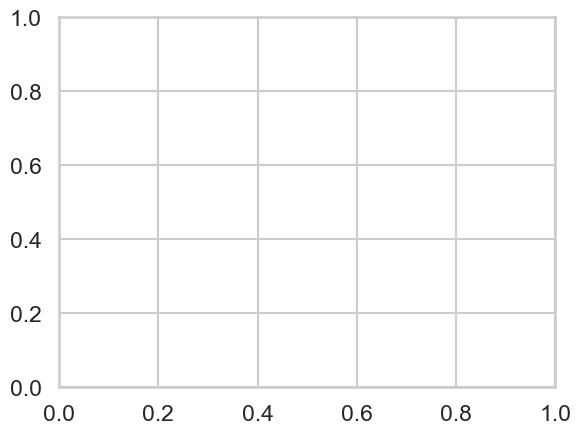

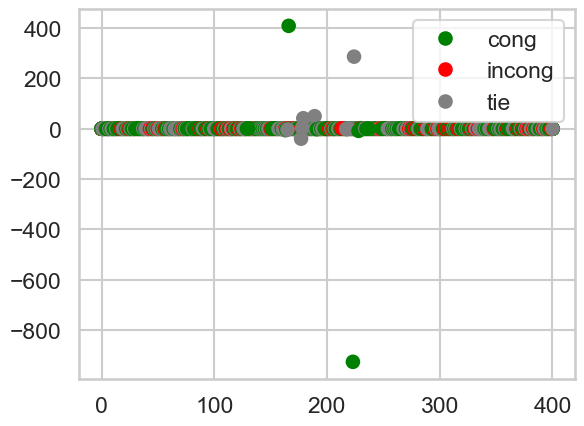

In [33]:
# This plots all of the points at the same time, so cannot filter out ties from it
# Which will be the next plot 
# cannot do something like rd = rd[rd[:,1]!=0] since it would change the x-axis

from matplotlib.colors import ListedColormap

plt.figure()
plt.cla()
fig, ax = plt.subplots()
colours = ListedColormap(['green','red','gray'])
labels = ['cong', 'incong', 'tie']

for r in range(runs):
        rd = ratio_diffs[r, :, :]
        xs = np.arange(checkpoints)
        scatter = ax.scatter(xs, rd[:,0], c=rd[:,1], cmap=colours)
        ax.legend(handles=scatter.legend_elements()[0], labels=labels)
        # ax.set_ylim([-0.1,0.1])
plt.show()   

In [38]:
# This plot first filtered out and grouped them based on the congruency 
# Then to make the x-axis size the same as the checkpoints, add nan to the data
# Then only plot for one run here since it was super messy and crowded only to look at the scatter 
# Also, another issue for all the runs: there are some very big or very small numbers


fig, ax = plt.subplots()
colours = ListedColormap(['green','red','gray'])
labels = ['cong', 'incong']
# 1: congruent, -1:incongruent, 0:none/ties

# for r in range(runs)
for r in range(1):
        rd  = ratio_diffs[r, :, :]
        
        cs   = [val if rd[ind,1]==1 else np.nan for ind, val in enumerate(rd[:,0])]
        incs = [val if rd[ind,1]==-1 else np.nan for ind, val in enumerate(rd[:,0])]
        ts   = [val if rd[ind,1]==0 else np.nan for ind, val in enumerate(rd[:,0])]
        
        cs = np.asarray(cs)
        incs = np.asarray(incs)
        ts = np.asarray(ts)

        mask1 = np.isfinite(cs)
        mask2 = np.isfinite(incs)
        mask3 = np.isfinite(ts)
        
        xs = np.arange(checkpoints)
        
        scatter1 = ax.scatter(xs[mask1], cs[mask1], c='green')
        scatter2 = ax.scatter(xs[mask2], incs[mask2], c='red')
        # scatter3 = ax.scatter(xs, ts, c='gray')
        
        # add lines
        # ax.plot(xs[mask3], ts[mask3])#, linestyle='-', marker='o')
        
        # UserWarning: Warning: converting a masked element to nan.
        ax.legend(handles=scatter.legend_elements()[0], labels=labels)
        

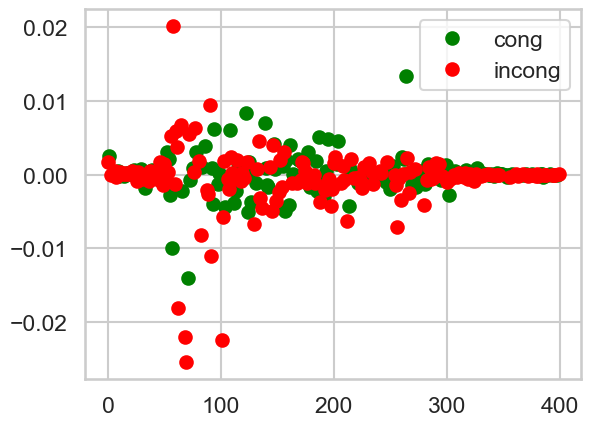

In [39]:
plt.show()

In [40]:
# for each congruency group, make a 2D matrix with the shape [runs, checkpoints]
# where all the missing values are nan
# one idea could be do the interpolation on the matrix instead of for ecah run separately
# I didn't do the interpolation, since interp2D and other functions I briefly looked 
# consider the matrix as a grid, so each point is different with the others
# However, I wanted it to interpolate each point by both looking at the all rows for that column 
# which gives all the info for all the runs, and looking at the columns for that row, to look at other
# checkpoints or maybe just nearby checkpoints, but I couldn't find a function for this 
# so I ended up using 1D interpolation


# css  = np.empty(shape=[runs, checkpoints])
# incs = np.empty(shape=[runs, checkpoints])
# tss  = np.empty(shape=[runs, checkpoints])

# css[:], incs[:], tss[:] = np.NaN, np.NaN, np.NaN

# for r in range(runs):
#     for cp in range(checkpoints):
#         if ratio_diffs[r, cp, 1] == 1:
#             css[r,cp] = ratio_diffs[r, cp, 0]
#         elif ratio_diffs[r, cp, 1] == -1:
#             incs[r,cp] = ratio_diffs[r, cp, 0]
#         elif ratio_diffs[r, cp, 1] == 0:
#             tss[r,cp] = ratio_diffs[r, cp, 0]



In [41]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [43]:
# import numpy as np
# from scipy import interpolate

def interp_func(A):
    '''
    interpolate to fill nan values
    '''
    nans, x = nan_helper(A)
    B = A.copy()
    B[nans]= np.interp(x(nans), x(~nans), A[~nans])
    # inds = np.arange(A.shape[0])
    # good = np.where(np.isfinite(A))
    # f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    # B = np.where(np.isfinite(A),A,f(inds))
    return B

In [52]:
# outliers can be between the 2 SD from the mean but it didn't result in a way I wanted
# since the mean would be affected by those very big and small numbers (why I used median)
# so for now I replaced the data with nan if the abs value is bigger than 1 

def nan_outliers(data, m=2):
    # outliers = abs(data - np.median(data)) < m * np.std(data)
    # for the nan it would show a warning:RuntimeWarning: invalid value encountered in greater
    outliers = abs(data)>1
    if len(np.where(outliers==True)[0])>0:
        print('data of the outlier(s):', data[outliers])
        print(len(outliers))
    data[outliers] = np.NaN
    return data
    

In [53]:
css   = np.empty(shape=[runs, checkpoints])
incss = np.empty(shape=[runs, checkpoints])
tss   = np.empty(shape=[runs, checkpoints])

for r in range(runs):
    # take the cong data, and do the interpolation for each run seaprately
    rd  = ratio_diffs[r, :, :]
    ids = [int(rd[i,1]) for i in range(checkpoints)]
    cs   = [val if rd[ind,1]==1 else np.nan for ind, val in enumerate(rd[:,0])]
    incs = [val if rd[ind,1]==-1 else np.nan for ind, val in enumerate(rd[:,0])]
    ts   = [val if rd[ind,1]==0 else np.nan for ind, val in enumerate(rd[:,0])]
    
    cs   = [val if rd[ind,1]==1 else np.nan for ind, val in enumerate(rd[:,0])]
    incs = [val if rd[ind,1]==-1 else np.nan for ind, val in enumerate(rd[:,0])]
    ts   = [val if rd[ind,1]==0 else np.nan for ind, val in enumerate(rd[:,0])]
    
    cs   = np.asarray(cs)
    incs = np.asarray(incs)
    ts   = np.asarray(ts)

    cs = nan_outliers(cs)
    incs = nan_outliers(incs)
    ts = nan_outliers(ts)

    cs_interp   = interp_func(cs)
    incs_interp = interp_func(incs)
    ts_interp   = interp_func(ts)

    css[r,:]   = cs_interp
    incss[r,:] = incs_interp
    tss[r,:]   = ts_interp
    

data of the outlier(s): [-1.40574646]
401
data of the outlier(s): [2.03683758]
401
data of the outlier(s): [ -6.31420898  -3.18238068 -39.56904602   3.88154602  41.69244385
  49.90600586  -1.27500534  -1.41228008   1.55973625 286.52487183]
401
data of the outlier(s): [   2.00082779   -2.4911499   408.97869873   -1.66740417 -926.45709229
   -8.46472931]
401
data of the outlier(s): [1.77169228]
401


/opt/anaconda3/envs/csls/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [54]:
# take avg over all the runs 
cs_avg = np.mean(css,axis=0)
incs_avg = np.mean(incss,axis=0)
ts_avg = np.mean(tss,axis=0)

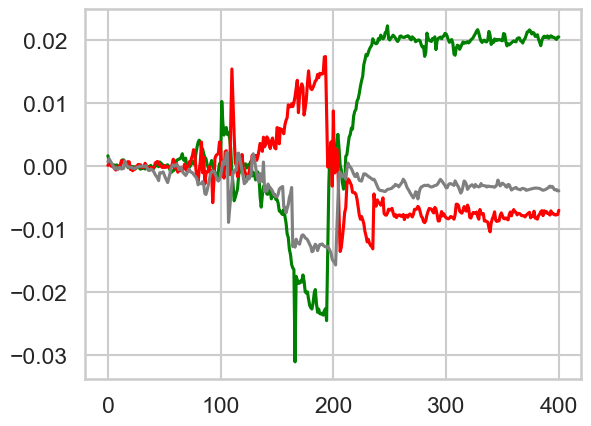

In [60]:
labels = ['cong', 'incong','ties']

plt.plot(cs_avg, color='green')
plt.plot(incs_avg, color='red')
plt.plot(ts_avg, color='gray')
# plt.ylim((-0.05, 0.05))
# ax.legend(labels=labels)
plt.show()

In [61]:
# do we need to even smooth more?